# Data Object Sampling

In [1]:
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

X = digits.data
y = digits.target

n_samples, n_features = X.shape

## Density Sampling

### Density Estimation

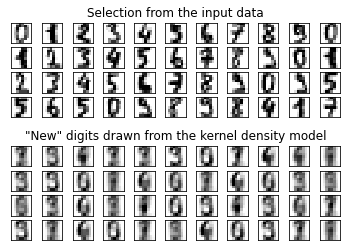

In [2]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

def scotts_factor(n_samples: int, n_features: int) -> float:
    return n_samples**(-1.0 / (n_features + 4))

# Project the 64-dimensional data to a lower dimension
# and do kernel density estimation in the low dimension space
pca = PCA(n_components=2, whiten=False)
X_pca = pca.fit_transform(X)
n_samples, n_features = X_pca.shape
bandwidth = scotts_factor(n_samples, n_features)
kde = KernelDensity(bandwidth=bandwidth).fit(X_pca)
log_density = kde.score_samples(X_pca)

# sample 44 new points from the data
new_data = kde.sample(44, random_state=0)
new_data = pca.inverse_transform(new_data)

# turn data into a 4x11 grid
new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# plot real digits and resampled digits
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]))
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(new_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)

ax[0, 5].set_title('Selection from the input data')
ax[5, 5].set_title('"New" digits drawn from the kernel density model')

plt.show()

### Sampling Score Distribution

In [3]:
import math
import altair as alt
import pandas as pd

alt.renderers.enable('default')

X_2d = X_pca
x = X_2d[:, 0]
y = X_2d[:, 1]

'''
xstep = (np.max(x) - np.min(x)) / 50
xmin = np.min(x) - xstep
xmax = np.max(x) + 2 * xstep
xgrid = np.arange(xmin, xmax, xstep)

ystep = (np.max(y) - np.min(y)) / 50
ymin = np.min(y) - ystep
ymax = np.max(y) + 2 * ystep
ygrid = np.arange(ymin, ymax, ystep)

'''
xstep = 1
xmin = math.floor(np.min(x)) - xstep
xmax = math.ceil(np.max(x)) + 2 * xstep
xgrid = np.arange(xmin, xmax, xstep)

ystep = 1
ymin = math.floor(np.min(y)) - xstep
ymax = math.ceil(np.max(y)) + 2 * xstep
ygrid = np.arange(ymin, ymax, ystep)


xmesh, ymesh = np.meshgrid(xgrid, ygrid)

X_grid = np.vstack([xmesh.ravel(), ymesh.ravel()]).T
log_density = kde.score_samples(X_grid + np.array([xstep/2, ystep/2]))

In [4]:
xscale = alt.Scale(domain=(min(X_grid[:, 0].tolist()), max(X_grid[:, 0].tolist())), nice=False)
yscale = alt.Scale(domain=(min(X_grid[:, 1].tolist()), max(X_grid[:, 1].tolist())), nice=False)

heatmap = alt.Chart(pd.DataFrame({
    'x': X_grid[:, 0],
    'y': X_grid[:, 1],
    'z': np.exp(log_density),
})).mark_rect().encode(
    x=alt.X('x:Q', scale=xscale, bin=alt.Bin(step=xstep), title='x'),
    y=alt.Y('y:Q', scale=yscale, bin=alt.Bin(step=ystep), title='y'),
    color=alt.Color('z:Q', title='score')
).properties(
    width=500,
    height=500,
)

scatterplot = alt.Chart(pd.DataFrame({
    'x': X_2d[:, 0],
    'y': X_2d[:, 1],
})).mark_circle().encode(
    x=alt.X('x:Q', scale=xscale),
    y=alt.Y('y:Q', scale=yscale),
)

(heatmap + scatterplot).properties(
    width=500,
    height=500,
)

alt.LayerChart(...)

## Cluster Sampling

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

X_2d = X_pca

n_clusters = 8
clusterer = KMeans(n_clusters=n_clusters, random_state=0).fit(X_2d)
cluster_centers = clusterer.cluster_centers_
cluster_labels = clusterer.labels_
cluster_sizes = np.array([np.sum(cluster_labels == i) for i in range(n_clusters)])

x = X_2d[:, 0]
y = X_2d[:, 1]

xstep = 1
xmin = math.floor(np.min(x)) - xstep
xmax = math.ceil(np.max(x)) + 2 * xstep
xgrid = np.arange(xmin, xmax, xstep)

ystep = 1
ymin = math.floor(np.min(y)) - xstep
ymax = math.ceil(np.max(y)) + 2 * xstep
ygrid = np.arange(ymin, ymax, ystep)

xmesh, ymesh = np.meshgrid(xgrid, ygrid)
X_grid = np.vstack([xmesh.ravel(), ymesh.ravel()]).T

K = rbf_kernel(X_grid, cluster_centers)
scores = K.dot(cluster_sizes)

In [6]:
xscale = alt.Scale(domain=(min(X_grid[:, 0].tolist()), max(X_grid[:, 0].tolist())), nice=False)
yscale = alt.Scale(domain=(min(X_grid[:, 1].tolist()), max(X_grid[:, 1].tolist())), nice=False)

heatmap = alt.Chart(pd.DataFrame({
    'x': X_grid[:, 0],
    'y': X_grid[:, 1],
    'z': scores,
})).mark_rect().encode(
    x=alt.X('x:Q', scale=xscale, bin=alt.Bin(step=xstep), title='x'),
    y=alt.Y('y:Q', scale=yscale, bin=alt.Bin(step=ystep), title='y'),
    color=alt.Color('z:Q', title='score')
).properties(
    width=500,
    height=500,
)

scatterplot = alt.Chart(pd.DataFrame({
    'x': X_2d[:, 0],
    'y': X_2d[:, 1],
    'cluster_labels': cluster_labels,
})).mark_circle().encode(
    x=alt.X('x:Q', scale=xscale),
    y=alt.Y('y:Q', scale=yscale),
    color=alt.Color('cluster_labels:N')
)

(heatmap + scatterplot).properties(
    width=500,
    height=500,
)

alt.LayerChart(...)